In [263]:
import matplotlib.pyplot as plt
import json
import torch
import pickle
from typing import Optional
from matplotlib.colors import Normalize
import numpy as np
import os

import experiments.utils as utils


DICTIONARIES_PATH = "../dictionary_learning/dictionaries"
# DICTIONARIES_PATH = "../dictionary_learning/dictionaries/gemma-2-2b-saved-data"
# DICTIONARIES_PATH = "../dictionary_learning/dictionaries/pythia70m-autointerp-results"

In [264]:
# There's a potential issue as we currently assume that all SAEs have the same classes.


def get_classes(first_path: str) -> list[int]:
    class_accuracies_file = f"{first_path}/class_accuracies.pkl"
    with open(class_accuracies_file, "rb") as f:
        class_accuracies = pickle.load(f)
    return list(class_accuracies["clean_acc"].keys())


def get_sparsity_penalty(config: dict, trainer_class: str) -> float:
    if trainer_class == "TrainerTopK":
        return config["trainer"]["k"]
    elif trainer_class == "PAnnealTrainer":
        return config["trainer"]["sparsity_penalty"]
    else:
        return config["trainer"]["l1_penalty"]


def get_l0_frac_recovered(ae_paths: list[str]) -> dict[str, dict[str, float]]:
    results = {}
    for ae_path in ae_paths:
        eval_results_file = f"{ae_path}/eval_results.json"
        if not os.path.exists(eval_results_file):
            print(f"Warning: {eval_results_file} does not exist.")
            continue

        with open(eval_results_file, "r") as f:
            eval_results = json.load(f)

        l0 = eval_results["l0"]
        frac_recovered = eval_results["frac_recovered"]

        results[ae_path] = {
            "l0": l0,
            "frac_recovered": frac_recovered,
        }

    return results


def add_ae_config_results(
    ae_paths: list[str], results: dict[str, dict[str, float]]
) -> dict[str, dict[str, float]]:
    for ae_path in ae_paths:
        config_file = f"{ae_path}/config.json"

        with open(config_file, "r") as f:
            config = json.load(f)

        trainer_class = config["trainer"]["trainer_class"]
        results[ae_path]["trainer_class"] = trainer_class
        results[ae_path]["l1_penalty"] = get_sparsity_penalty(config, trainer_class)

        results[ae_path]["lr"] = config["trainer"]["lr"]
        results[ae_path]["dict_size"] = config["trainer"]["dict_size"]
        if "steps" in config["trainer"]:
            results[ae_path]["steps"] = config["trainer"]["steps"]

    return results


def add_ablation_diff_plotting_dict(
    ae_paths: list[str],
    results: dict[str, dict[str, float]],
    threshold: float,
    intended_filter_class_ids: list[int],
    unintended_filter_class_ids: list[int],
    filename_counter: str,
    acc_key: str = "acc",
) -> dict:
    for ae_path in ae_paths:
        intended_diffs = []
        unintended_diffs = []

        class_accuracies_file = f"{ae_path}/class_accuracies{filename_counter}.pkl"

        if not os.path.exists(class_accuracies_file):
            print(
                f"Warning: {class_accuracies_file} does not exist. Removing this path from results."
            )
            del results[ae_path]
            continue

        with open(class_accuracies_file, "rb") as f:
            class_accuracies = pickle.load(f)

        classes = list(class_accuracies["clean_acc"].keys())

        # print(class_accuracies)
        # for class_id in classes:
        #     print(class_accuracies["clean_acc"][class_id]["acc"])

        for class_id in classes:
            if isinstance(class_id, str) and " probe on " in class_id:
                continue

            if intended_filter_class_ids and class_id not in intended_filter_class_ids:
                continue

            clean = class_accuracies["clean_acc"][class_id]["acc"]
            # print(ae_path)
            # print(class_accuracies[class_id])
            patched = class_accuracies[class_id][threshold][class_id][acc_key]

            diff = clean - patched
            intended_diffs.append(diff)

        for intended_class_id in classes:
            if isinstance(intended_class_id, str) and " probe on " in intended_class_id:
                continue

            if intended_filter_class_ids and intended_class_id not in intended_filter_class_ids:
                continue

            for unintended_class_id in classes:
                if intended_class_id == unintended_class_id:
                    continue

                if (
                    unintended_filter_class_ids
                    and unintended_class_id not in unintended_filter_class_ids
                ):
                    continue

                if isinstance(unintended_class_id, str) and " probe on " in unintended_class_id:
                    continue

                clean = class_accuracies["clean_acc"][unintended_class_id]["acc"]
                patched = class_accuracies[intended_class_id][threshold][unintended_class_id][
                    acc_key
                ]
                diff = clean - patched
                unintended_diffs.append(diff)

        average_intended_diff = sum(intended_diffs) / len(intended_diffs)
        average_unintended_diff = sum(unintended_diffs) / len(unintended_diffs)
        average_diff = average_intended_diff - average_unintended_diff

        results[ae_path]["average_diff"] = average_diff
        results[ae_path]["average_intended_diff"] = average_intended_diff
        results[ae_path]["average_unintended_diff"] = average_unintended_diff

    return results


In [265]:
def filter_by_l0_threshold(results: dict, l0_threshold: Optional[int]) -> dict:
    if l0_threshold is not None:
        filtered_results = {
            path: data for path, data in results.items() if data["l0"] <= l0_threshold
        }

        # Optional: Print how many results were filtered out
        filtered_count = len(results) - len(filtered_results)
        print(f"Filtered out {filtered_count} results with L0 > {l0_threshold}")

        # Replace the original results with the filtered results
        results = filtered_results
    return results

In [266]:
# “Gated SAE”, “Gated SAE w/ p-annealing”, “Standard”, “Standard w/ p-annealing”
label_lookup = {
    "StandardTrainer": "Standard",
    # "PAnnealTrainer": "Standard w/ p-annealing",
    # "GatedSAETrainer": "Gated SAE",
    "TrainerJumpRelu": "JumpReLU",
    # "GatedAnnealTrainer": "Gated SAE w/ p-annealing",
    "TrainerTopK": "Top K",
    # "Identity": "Identity",
}

unique_trainers = list(label_lookup.keys())

# create a dictionary mapping trainer types to marker shapes

trainer_markers = {
    "StandardTrainer": "o",
    "TrainerJumpRelu": "X",
    "TrainerTopK": "^",
    "GatedSAETrainer": "d",
}


# default text size
plt.rcParams.update({"font.size": 16})


def plot_3var_graph(
    results: dict,
    title: str,
    custom_metric: str,
    xlims: Optional[tuple[float, float]] = None,
    ylims: Optional[tuple[float, float]] = None,
    colorbar_label: str = "Average Diff",
    output_filename: Optional[str] = None,
    legend_location: str = "lower right",
):
    # Extract data from results
    l0_values = [data["l0"] for data in results.values()]
    frac_recovered_values = [data["frac_recovered"] for data in results.values()]
    average_diff_values = [data[custom_metric] for data in results.values()]

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a normalize object for color scaling
    norm = Normalize(vmin=min(average_diff_values), vmax=max(average_diff_values))

    handles, labels = [], []

    for trainer, marker in trainer_markers.items():
        # Filter data for this trainer
        trainer_data = {k: v for k, v in results.items() if v["trainer_class"] == trainer}

        if not trainer_data:
            continue  # Skip this trainer if no data points

        l0_values = [data["l0"] for data in trainer_data.values()]
        frac_recovered_values = [data["frac_recovered"] for data in trainer_data.values()]
        average_diff_values = [data[custom_metric] for data in trainer_data.values()]

        # Plot data points
        scatter = ax.scatter(
            l0_values,
            frac_recovered_values,
            c=average_diff_values,
            cmap="viridis",
            marker=marker,
            s=100,
            label=label_lookup[trainer],
            norm=norm,
            edgecolor="black",
        )

        # custom legend stuff
        _handle, _ = scatter.legend_elements(prop="sizes")
        _handle[0].set_markeredgecolor("black")
        _handle[0].set_markerfacecolor("white")
        _handle[0].set_markersize(10)
        if marker == "d":
            _handle[0].set_markersize(13)
        handles += _handle
        labels.append(label_lookup[trainer])

    # Add colorbar
    cbar = fig.colorbar(scatter, ax=ax, label=colorbar_label)

    # Set labels and title
    ax.set_xlabel("L0")
    ax.set_ylabel("Fraction Recovered")
    ax.set_title(title)

    ax.legend(handles, labels, loc=legend_location)

    # Set axis limits
    if xlims:
        ax.set_xlim(*xlims)
    if ylims:
        ax.set_ylim(*ylims)

    plt.tight_layout()

    # Save and show the plot
    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight")
    plt.show()


# print(results)
# if include_diff:
# plot_3var_graph(results)


In [267]:
import plotly.graph_objects as go
from typing import Optional, Dict, Any


def plot_interactive_3var_graph(
    results: Dict[str, Dict[str, float]],
    custom_color_metric: str,
    xlims: Optional[tuple[float, float]] = None,
    y_lims: Optional[tuple[float, float]] = None,
    output_filename: Optional[str] = None,
):
    # Extract data from results
    ae_paths = list(results.keys())
    l0_values = [data["l0"] for data in results.values()]
    frac_recovered_values = [data["frac_recovered"] for data in results.values()]

    custom_metric_value = [data[custom_color_metric] for data in results.values()]

    dict_size = [data["dict_size"] for data in results.values()]
    lr = [data["lr"] for data in results.values()]
    l1_penalty = [data["l1_penalty"] for data in results.values()]

    # Create the scatter plot
    fig = go.Figure()

    # Add trace
    fig.add_trace(
        go.Scatter(
            x=l0_values,
            y=frac_recovered_values,
            mode="markers",
            marker=dict(
                size=10,
                color=custom_metric_value,  # Color points based on frac_recovered
                colorscale="Viridis",  # You can change this colorscale
                showscale=True,
            ),
            text=[
                f"AE Path: {ae}<br>L0: {l0:.4f}<br>Frac Recovered: {fr:.4f}<br>Custom Metric: {ad:.4f}<br>Dict Size: {d:.4f}<br>LR: {l:.4f}<br>L1 Penalty: {l1:.4f}"
                for ae, l0, fr, ad, d, l, l1 in zip(
                    ae_paths,
                    l0_values,
                    frac_recovered_values,
                    custom_metric_value,
                    dict_size,
                    lr,
                    l1_penalty,
                )
            ],
            hoverinfo="text",
        )
    )

    # Update layout
    fig.update_layout(
        title="L0 vs Fraction Recovered",
        xaxis_title="L0",
        yaxis_title="Fraction Recovered",
        hovermode="closest",
    )

    # Set axis limits
    if xlims:
        fig.update_xaxes(range=xlims)
    if y_lims:
        fig.update_yaxes(range=y_lims)

    # Save and show the plot
    if output_filename:
        fig.write_html(output_filename)

    fig.show()


# Example usage:
# plot_interactive_3var_graph(results)

In [268]:
def plot_2var_graph(
    results: dict,
    xlims: Optional[tuple[float, float]] = None,
    y_lims: Optional[tuple[float, float]] = None,
    output_filename: Optional[str] = None,
):
    # Extract data from results
    l0_values = [data["l0"] for data in results.values()]
    frac_recovered_values = [data["frac_recovered"] for data in results.values()]

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot data points
    ax.scatter(
        l0_values,
        frac_recovered_values,
        s=100,
        edgecolor="black",
        c="blue",  # You can change this color as needed
    )

    # Set labels and title
    ax.set_xlabel("L0")
    ax.set_ylabel("Fraction Recovered")
    ax.set_title("L0 vs Fraction Recovered")

    # Set axis limits
    if xlims:
        ax.set_xlim(*xlims)
    if y_lims:
        ax.set_ylim(*y_lims)

    plt.tight_layout()

    # Save and show the plot
    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight")
    plt.show()


# Example usage:
# plot_2var_graph(results)

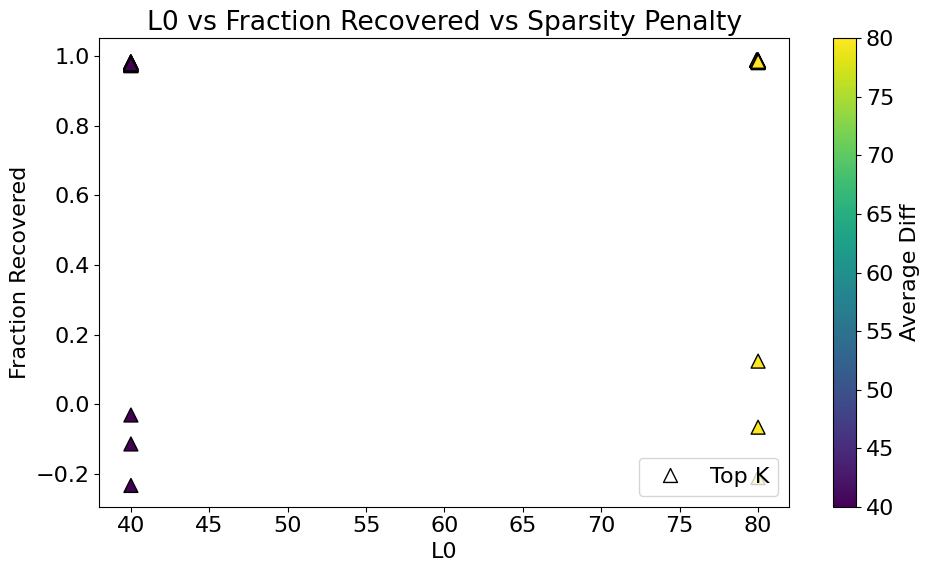

In [269]:
# Another way to generate graphs, where you manually populate sweep_name and submodule_trainers
sweep_name = "pythia70m_test_sae"
submodule_trainers = {"resid_post_layer_3": {"trainer_ids": [0]}}

# Current recommended way to generate graphs. You can copy paste ae_sweep_paths directly from bib_intervention.py
ae_sweep_paths = {
    "pythia70m_sweep_standard_ctx128_0712": {"resid_post_layer_3": {"trainer_ids": [1, 7, 11, 18]}}
}

# trainer_ids = [2, 6, 10, 14, 18]
trainer_ids = None

ae_sweep_paths = {
    "pythia70m_sweep_standard_ctx128_0712": {
        # "resid_post_layer_0": {"trainer_ids": None},
        # "resid_post_layer_1": {"trainer_ids": None},
        # "resid_post_layer_2": {"trainer_ids": None},
        "resid_post_layer_3": {"trainer_ids": trainer_ids},
        # "resid_post_layer_4": {"trainer_ids": None},
    },
    "pythia70m_sweep_topk_ctx128_0730": {
        # "resid_post_layer_0": {"trainer_ids": None},
        # "resid_post_layer_1": {"trainer_ids": None},
        # "resid_post_layer_2": {"trainer_ids": None},
        # "resid_post_layer_3": {"trainer_ids": None},
        # "resid_post_layer_4": {"trainer_ids": None},
        "resid_post_layer_3": {"trainer_ids": trainer_ids},
    },
    # "pythia70m_sweep_gated_ctx128_0730": {
    #     # "resid_post_layer_0": {"trainer_ids": None},
    #     # "resid_post_layer_1": {"trainer_ids": None},
    #     # "resid_post_layer_2": {"trainer_ids": None},
    #     # "resid_post_layer_3": {"trainer_ids": None},
    #     # "resid_post_layer_4": {"trainer_ids": None},
    #     "resid_post_layer_3": {"trainer_ids": trainer_ids},
    # },
}

# ae_sweep_paths = {
#     "pythia70m_sweep_topk_ctx128_0730": {
#         # "resid_post_layer_0": {"trainer_ids": None},
#         # "resid_post_layer_1": {"trainer_ids": None},
#         # "resid_post_layer_2": {"trainer_ids": None},
#         "resid_post_layer_3": {"trainer_ids": None},
#         # "resid_post_layer_4": {"trainer_ids": None},
#     }
# }

trainer_ids = None
# trainer_ids = [1]

ae_sweep_paths = {
    "gemma-2-2b_sweep_standard_ctx128_ef8_0824": {
        # "resid_post_layer_12": {"trainer_ids": trainer_ids},
        "resid_post_layer_15": {"trainer_ids": trainer_ids},
        # "resid_post_layer_19": {"trainer_ids": trainer_ids},
        # "resid_post_layer_20": {"trainer_ids": trainer_ids},
    },
    "gemma-2-2b_sweep_topk_ctx128_ef8_0824": {
        # "resid_post_layer_12": {"trainer_ids": trainer_ids},
        # "resid_post_layer_11": {"trainer_ids": trainer_ids},
        "resid_post_layer_15": {"trainer_ids": trainer_ids},
        # "resid_post_layer_19": {"trainer_ids": trainer_ids},
        # "resid_post_layer_20": {"trainer_ids": trainer_ids},
    },
    "gemma-2-2b_sweep_jumprelu_0902": {
        "resid_post_layer_15": {"trainer_ids": trainer_ids},
        # "resid_post_layer_19": {"trainer_ids": trainer_ids},
    },
}

# trainer_ids = None
# ae_sweep_paths = {
#     "gemma-2-2b_sweep_jumprelu_0902_probe_layer24_results": {
#         "resid_post_layer_11": {"trainer_ids": trainer_ids},
#     },
#     "gemma-2-2b_sweep_standard_ctx128_ef8_0824_probe_layer24_results": {
#         "resid_post_layer_11": {"trainer_ids": trainer_ids},
#     },
#     "gemma-2-2b_sweep_topk_ctx128_ef8_0824_probe_layer24_results": {
#         "resid_post_layer_11": {"trainer_ids": trainer_ids},
#     },
#     "gemma-2-2b_sweep_standard_ctx128_ef2_0824_probe_layer_24_results": {
#         "resid_post_layer_11": {"trainer_ids": trainer_ids},
#     },
#     "gemma-2-2b_sweep_topk_ctx128_ef2_0824_probe_layer_24_results": {
#         "resid_post_layer_11": {"trainer_ids": trainer_ids},
#     },
# }

# ae_sweep_paths = {
#     "gemma-2-2b_sweep_standard_ctx128_ef8_0824_probe_layer20_results": {
#         "resid_post_layer_11": {"trainer_ids": trainer_ids},
#     },
#     "gemma-2-2b_sweep_topk_ctx128_ef8_0824_probe_layer20_results": {
#         "resid_post_layer_11": {"trainer_ids": trainer_ids},
#     },
# }

ae_sweep_paths = {
    "gemma-2-2b_sweep_topk_ctx128_ef8_0824": {
        "resid_post_layer_11_checkpoints": {"trainer_ids": trainer_ids},
        "resid_post_layer_15_checkpoints": {"trainer_ids": trainer_ids},
        "resid_post_layer_19_checkpoints": {"trainer_ids": trainer_ids},
    },
}


sweep_name = list(ae_sweep_paths.keys())[0]
submodule_trainers = ae_sweep_paths[sweep_name]


ae_paths = []

for sweep_name, submodule_trainers in ae_sweep_paths.items():
    ae_group_paths = utils.get_ae_group_paths(DICTIONARIES_PATH, sweep_name, submodule_trainers)
    ae_paths.extend(utils.get_ae_paths(ae_group_paths))

l0_loss_recovered_results = get_l0_frac_recovered(ae_paths)
plotting_results = add_ae_config_results(ae_paths, l0_loss_recovered_results)

filename_filter = ""

l0_threshold = 500
l0_threshold = None

plotting_results = filter_by_l0_threshold(plotting_results, l0_threshold)

title = "L0 vs Fraction Recovered vs Sparsity Penalty"

custom_metric = "l1_penalty"

plot_3var_graph(plotting_results, title, custom_metric)
plot_interactive_3var_graph(plotting_results, custom_metric)

# At this point, if there's any additional .json files located alongside the ae.pt and eval_results.json
# You can easily adapt them to be included in the plotting_results dictionary by using something similar to add_ae_config_results()

['../dictionary_learning/dictionaries/gemma-2-2b_sweep_topk_ctx128_ef8_0824/resid_post_layer_11_checkpoints/trainer_1_step_0', '../dictionary_learning/dictionaries/gemma-2-2b_sweep_topk_ctx128_ef8_0824/resid_post_layer_11_checkpoints/trainer_1_step_19528', '../dictionary_learning/dictionaries/gemma-2-2b_sweep_topk_ctx128_ef8_0824/resid_post_layer_11_checkpoints/trainer_1_step_29292', '../dictionary_learning/dictionaries/gemma-2-2b_sweep_topk_ctx128_ef8_0824/resid_post_layer_11_checkpoints/trainer_1_step_4882', '../dictionary_learning/dictionaries/gemma-2-2b_sweep_topk_ctx128_ef8_0824/resid_post_layer_11_checkpoints/trainer_1_step_9764', '../dictionary_learning/dictionaries/gemma-2-2b_sweep_topk_ctx128_ef8_0824/resid_post_layer_11_checkpoints/trainer_2_step_0', '../dictionary_learning/dictionaries/gemma-2-2b_sweep_topk_ctx128_ef8_0824/resid_post_layer_11_checkpoints/trainer_2_step_19528', '../dictionary_learning/dictionaries/gemma-2-2b_sweep_topk_ctx128_ef8_0824/resid_post_layer_11_chec

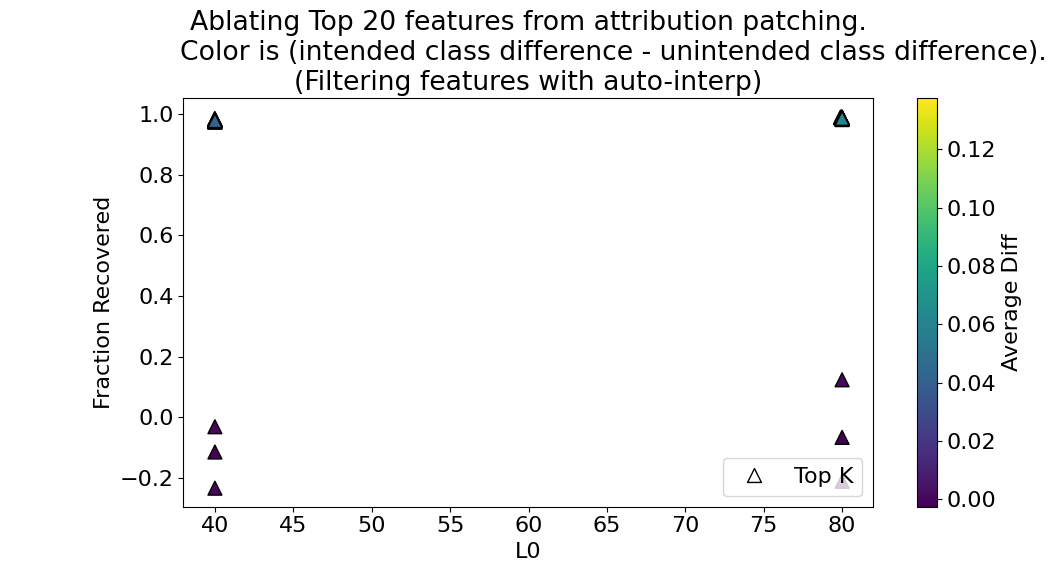

In [306]:
print(ae_paths)

# If not empty, this will filter to only include the specified class ids
intended_filter_class_ids = ["male / female", "professor / nurse"]
unintended_filter_class_ids = ["male / female", "professor / nurse"]
# intended_filter_class_ids = [0, 1, 2, 6]
# unintended_filter_class_ids = [0, 1, 2, 6]
# intended_filter_class_ids = ["male / female"]
# unintended_filter_class_ids = [1]
# unintended_filter_class_ids = [-4]

threshold = 0.1
threshold = 20

filename_filter = "_attrib"
filename_filter = "_auto_interp"

try:
    results_acc = add_ablation_diff_plotting_dict(
        ae_paths,
        plotting_results,
        threshold,
        intended_filter_class_ids,
        unintended_filter_class_ids,
        filename_filter,
        "acc",
    )
    # results_acc0 = add_ablation_diff_plotting_dict(
    #     ae_paths,
    #     plotting_results,
    #     threshold,
    #     intended_filter_class_ids,
    #     unintended_filter_class_ids,
    #     filename_counter,
    #     "loss"
    # )

    # l0_threshold = None
    # l0_threshold = 500

    custom_metric1 = "average_diff"
    custom_metric2 = "average_intended_diff"
    custom_metric3 = "average_unintended_diff"

    auto_interp_title = ""

    if "auto_interp" in filename_filter:
        auto_interp_title = "\n(Filtering features with auto-interp)"

    title = f"""Ablating Top {threshold} features from attribution patching.
                    Color is (intended class difference - unintended class difference).{auto_interp_title}"""

    # results_acc = filter_by_l0_threshold(results_acc, l0_threshold)
    # results_acc0 = filter_by_l0_threshold(results_acc0, l0_threshold)

    plot_3var_graph(results_acc, title, custom_metric1)
    plot_interactive_3var_graph(results_acc, custom_metric1)
    # plot_3var_graph(results_acc0, title, custom_metric1)
    # plot_3var_graph(results, title, custom_metric3)
except Exception as e:
    print("Error plotting, possibly due to missing class accuracies file.")
    print(e)

Original acc: 0.5949999690055847
Original acc: 0.5949999690055847
Original acc: 0.5949999690055847
Original acc: 0.5949999690055847
Original acc: 0.5949999690055847
Original acc: 0.5949999690055847
Original acc: 0.5949999690055847
Original acc: 0.5949999690055847
Original acc: 0.5949999690055847
Original acc: 0.5949999690055847
Original acc: 0.5949999690055847
Original acc: 0.5949999690055847
Original acc: 0.6100000143051147
Original acc: 0.6100000143051147
Original acc: 0.6100000143051147
Original acc: 0.6100000143051147
Original acc: 0.6100000143051147
Original acc: 0.6100000143051147
Original acc: 0.6100000143051147
Original acc: 0.6100000143051147
Original acc: 0.6100000143051147
Original acc: 0.6100000143051147
Original acc: 0.6100000143051147
Original acc: 0.6100000143051147
Original acc: 0.5949999690055847
Original acc: 0.5949999690055847
Original acc: 0.5949999690055847
Original acc: 0.5949999690055847
Original acc: 0.5949999690055847
Original acc: 0.5949999690055847
Original a

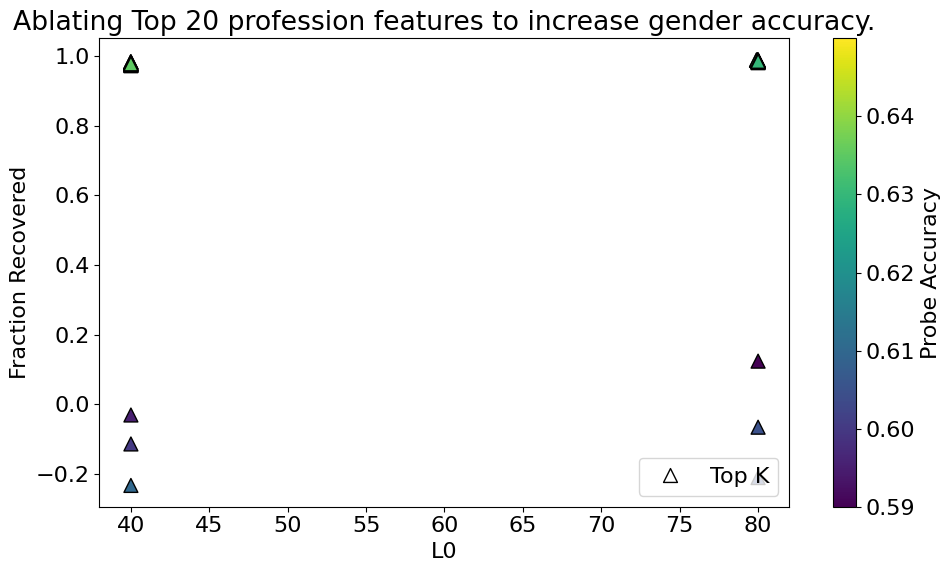

In [307]:
def get_spurious_correlation_plotting_dict(
    ae_paths: list[str],
    threshold: float,
    ablated_probe_class_id: str,
    eval_probe_class_id: str,
    eval_data_class_id: str,
    filename_counter: str,
    acc_key: str = "acc",
) -> tuple[dict[str, dict[str, float]], float]:
    results = {}
    orig_acc = None

    for ae_path in ae_paths:
        eval_results_file = f"{ae_path}/eval_results.json"

        if not os.path.exists(eval_results_file):
            print(f"Warning: {eval_results_file} does not exist.")
            continue

        with open(eval_results_file, "r") as f:
            eval_results = json.load(f)

        l0 = eval_results["l0"]
        frac_recovered = eval_results["frac_recovered"]

        results[ae_path] = {
            "l0": l0,
            "frac_recovered": frac_recovered,
        }

        config_file = f"{ae_path}/config.json"

        with open(config_file, "r") as f:
            config = json.load(f)

        trainer_class = config["trainer"]["trainer_class"]
        results[ae_path]["trainer_class"] = trainer_class
        results[ae_path]["l1_penalty"] = get_sparsity_penalty(config, trainer_class)

        results[ae_path]["lr"] = config["trainer"]["lr"]
        results[ae_path]["dict_size"] = config["trainer"]["dict_size"]
        if "steps" in config["trainer"]:
            results[ae_path]["steps"] = config["trainer"]["steps"]

        class_accuracies_file = f"{ae_path}/class_accuracies{filename_counter}.pkl"

        if not os.path.exists(class_accuracies_file):
            print(
                f"Warning: {class_accuracies_file} does not exist. Removing this path from results."
            )
            del results[ae_path]
            continue

        with open(class_accuracies_file, "rb") as f:
            class_accuracies = pickle.load(f)

        # for class_id in class_accuracies['clean_acc']:
        #     print(class_id, class_accuracies['clean_acc'][class_id])

        combined_class_name = f"{eval_probe_class_id} probe on {eval_data_class_id} data"

        original_acc = class_accuracies["clean_acc"][combined_class_name]["acc"]
        if orig_acc is None:
            orig_acc = original_acc
        print(f"Original acc: {original_acc}")

        changed_acc = class_accuracies[ablated_probe_class_id][threshold][combined_class_name][
            acc_key
        ]

        results[ae_path]["average_diff"] = changed_acc
    return results, orig_acc


ablated_probe_class_id = "male / female"
# ablated_probe_class_id = "professor / nurse"
# ablated_probe_class_id = "male_professor / female_nurse"
eval_probe_class_id = "male_professor / female_nurse"
eval_probe_class_id = "male_professor / female_nurse"
# eval_probe_class_id = "biased_male / biased_female"
# ablated_probe_class_id = eval_probe_class_id
eval_data_class_id = "professor / nurse"
eval_data_class_id = "male / female"

threshold = 20

filename_filter = "_attrib"
# filename_filter = "_auto_interp"
# filename_filter = "_bias_shift_dir2"

attrib_dir = 2

if  "_bias_shift" in filename_filter:
    ablated_probe_class_id = eval_probe_class_id

    if filename_filter == "_bias_shift_dir1":
        title = f"""Ablating Top {threshold} gender features to increase profession accuracy."""
        eval_data_class_id = "professor / nurse"
    elif filename_filter == "_bias_shift_dir2":
        title = f"""Ablating Top {threshold} profession features to increase gender accuracy."""
        eval_data_class_id = "male / female"
    else:
        raise ValueError("Invalid filename filter.")
    title += "\nFiltering features with auto-interp."
else:
    if attrib_dir == 1:
        ablated_probe_class_id = "male / female"
        eval_data_class_id = "professor / nurse"
        title = f"""Ablating Top {threshold} gender features to increase profession accuracy."""
    elif attrib_dir == 2:
        ablated_probe_class_id = "professor / nurse"
        eval_data_class_id = "male / female"
        title = f"""Ablating Top {threshold} profession features to increase gender accuracy."""
    else:
        raise ValueError("Invalid attrib_dir.")



spurious_correlation_results, original_acc = get_spurious_correlation_plotting_dict(
    ae_paths,
    threshold,
    ablated_probe_class_id,
    eval_probe_class_id,
    eval_data_class_id,
    filename_filter,
    "acc",
)

# title += f"\nOriginal Accuracy: {original_acc:.4f}"

l0_threshold = None
# l0_threshold = 500

custom_metric1 = "average_diff"

spurious_correlation_results = filter_by_l0_threshold(spurious_correlation_results, l0_threshold)

plot_3var_graph(
    spurious_correlation_results, title, custom_metric1, colorbar_label="Probe Accuracy"
)
plot_interactive_3var_graph(spurious_correlation_results, custom_metric1)
# plot_3var_graph(results_acc0, title, custom_metric1)
# plot_3var_graph(results, title, custom_metric3)

Original acc: 0.5949999690055847


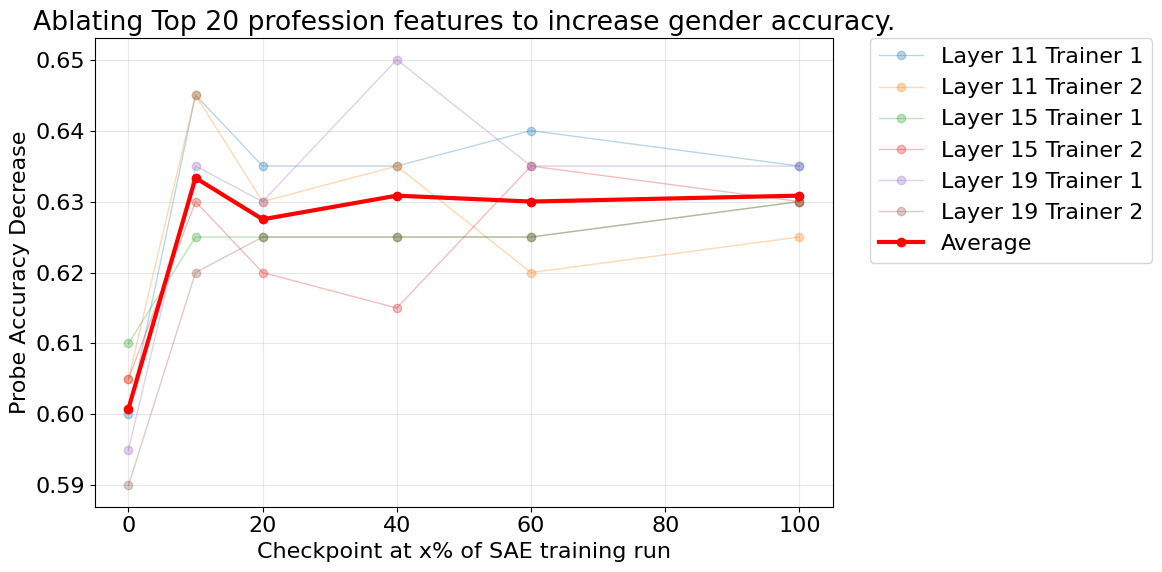

In [308]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional
from collections import defaultdict

def plot_steps_vs_average_diff(
    results_dict: dict,
    steps_key: str = "steps",
    avg_diff_key: str = "average_diff",
    title: Optional[str] = None,
    y_label: Optional[str] = None,
):
    # Initialize a defaultdict to store data for each trainer
    trainer_data = defaultdict(lambda: {'steps': [], 'average_diffs': []})

    all_steps = set()

    # Extract data from the dictionary
    for key, value in results_dict.items():
        # Extract trainer number from the key
        trainer = key.split('/')[-1].split('_')[1]  # Assuming format like "trainer_1_..."
        layer = key.split('/')[-2].split('_')[-2]
        step = int(value[steps_key])
        avg_diff = value[avg_diff_key]

        trainer_key = f"Layer {layer} Trainer {trainer}"

        trainer_data[trainer_key]['steps'].append(step)
        trainer_data[trainer_key]['average_diffs'].append(avg_diff)
        all_steps.add(step)

    # Calculate average across all trainers
    average_trainer_data = {'steps': [], 'average_diffs': []}
    for step in sorted(all_steps):
        step_diffs = []
        for data in trainer_data.values():
            if step in data['steps']:
                idx = data['steps'].index(step)
                step_diffs.append(data['average_diffs'][idx])
        if step_diffs:
            average_trainer_data['steps'].append(step)
            average_trainer_data['average_diffs'].append(np.mean(step_diffs))

    # Add average_trainer_data to trainer_data
    trainer_data['Average'] = average_trainer_data

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot data for each trainer
    for trainer_key, data in trainer_data.items():
        steps = data['steps']
        average_diffs = data['average_diffs']

        # Sort the data by steps to ensure proper ordering
        sorted_data = sorted(zip(steps, average_diffs))
        steps, average_diffs = zip(*sorted_data)

        # Find the maximum step value for this trainer
        max_step = max(steps)

        # Convert steps to percentages of max_step
        step_percentages = [step / max_step * 100 for step in steps]

        # Plot the line for this trainer
        if trainer_key == 'Average':
            plt.plot(step_percentages, average_diffs, marker="o", label=trainer_key, 
                     linewidth=3, color='red', zorder=10)  # Emphasized average line
        else:
            plt.plot(step_percentages, average_diffs, marker="o", label=trainer_key, 
                     alpha=0.3, linewidth=1)  # More transparent individual lines

    if not title:
        title = f'{steps_key.capitalize()} vs {avg_diff_key.replace("_", " ").capitalize()}'

    if not y_label:
        y_label = avg_diff_key.replace("_", " ").capitalize()

    plt.xlabel("Checkpoint at x% of SAE training run")
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True, alpha=0.3)  # More transparent grid

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# checkpoints_title = "Training steps vs Decrease in Probe Accuracy"
y_label = "Probe Accuracy Decrease"

# try:
#     plot_steps_vs_average_diff(plotting_results, title=checkpoints_title, y_label=y_label)
# except Exception as e:
#     print(f"Error plotting: {e}")

print(f"Original acc: {original_acc}")

# If your keys are different, you can specify them:
plot_steps_vs_average_diff(
    spurious_correlation_results,
    steps_key="steps",
    avg_diff_key=custom_metric1,
    title=title,
    y_label=y_label,
)

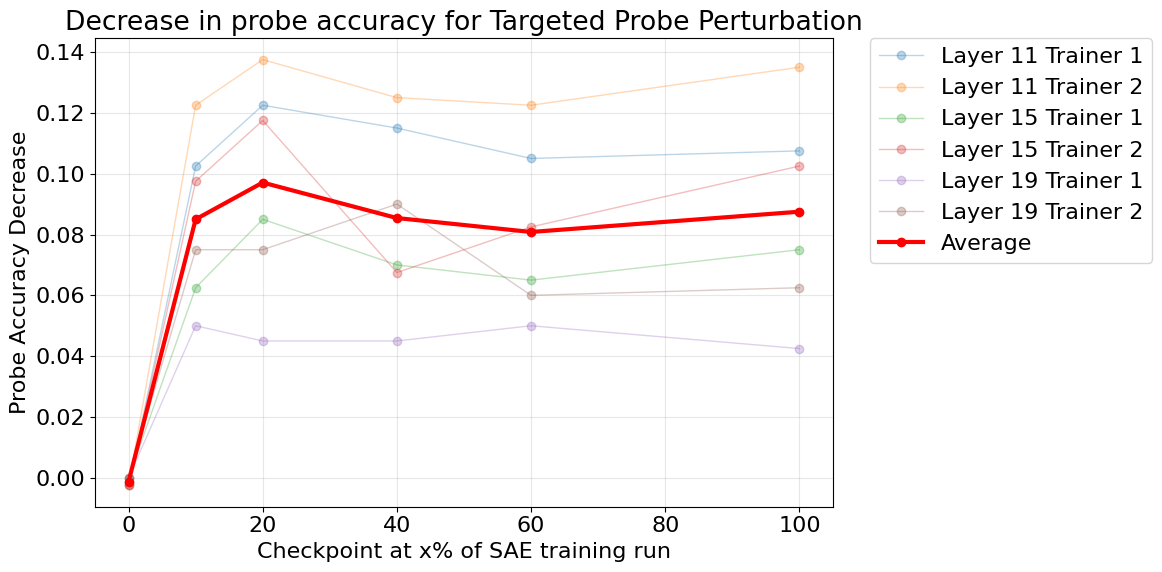

In [309]:

# tpp_title = f"Decrease in probe accuracy for Targeted Probe Perturbation"

# plot_steps_vs_average_diff(
#     results_acc,
#     steps_key="steps",
#     avg_diff_key=custom_metric1,
#     title=tpp_title,
#     y_label=y_label,
# )